In [1]:
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import h5py
import numpy as np
# import jax
# import jax.numpy as jnp
# import haiku as hk
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import initializers

np.random.seed(8)
tf.random.set_seed(8)

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
f = h5py.File('/clusterfs/ml4hep/mfong/transfer_learning/delphes_train.h5', 'r')
f2 = h5py.File('/clusterfs/ml4hep/mfong/transfer_learning/delphes_test.h5', 'r')

In [4]:
feature_keys = ['fjet_clus_eta', 'fjet_clus_phi', 'fjet_clus_pt']
for k in f.keys():
    print(k, f[k].shape)

fjet_clus_E (4000068, 200)
fjet_clus_eta (4000068, 200)
fjet_clus_phi (4000068, 200)
fjet_clus_pt (4000068, 200)
fjet_eta (4000068,)
fjet_m (4000068,)
fjet_phi (4000068,)
fjet_pt (4000068,)
labels (4000068,)


In [5]:
x = np.concatenate([f[k] for k in feature_keys], axis=1)
x.shape

(4000068, 600)

In [6]:
y = f["labels"][:]
y.shape

(4000068,)

In [7]:
num_samples = len(y)
num_train_samples = int(0.8 * num_samples)
x_train = x[:num_train_samples]
y_train = y[:num_train_samples]

x_test = x[num_train_samples:]
y_test = y[num_train_samples:]

In [8]:
scaler = StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

## Fully Connected NN

In [ ]:
model = Sequential()
model.add(Dense(64, input_shape=(600,), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [133]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=800, batch_size=256, shuffle=True, validation_data=(x_test, y_test))

Epoch 1/1000
12501/12501 [==============================] - 35s 3ms/step - loss: 0.4352 - accuracy: 0.7934 - val_loss: 0.4302 - val_accuracy: 0.7964
Epoch 2/1000
12501/12501 [==============================] - 35s 3ms/step - loss: 0.4263 - accuracy: 0.7983 - val_loss: 0.4243 - val_accuracy: 0.8000
Epoch 3/1000
12501/12501 [==============================] - 33s 3ms/step - loss: 0.4227 - accuracy: 0.8004 - val_loss: 0.4210 - val_accuracy: 0.8017
Epoch 4/1000
12501/12501 [==============================] - 36s 3ms/step - loss: 0.4203 - accuracy: 0.8019 - val_loss: 0.4194 - val_accuracy: 0.8028
Epoch 5/1000
12501/12501 [==============================] - 36s 3ms/step - loss: 0.4189 - accuracy: 0.8028 - val_loss: 0.4184 - val_accuracy: 0.8032
Epoch 6/1000
12501/12501 [==============================] - 36s 3ms/step - loss: 0.4179 - accuracy: 0.8035 - val_loss: 0.4185 - val_accuracy: 0.8030
Epoch 7/1000
12501/12501 [==============================] - 36s 3ms/step - loss: 0.4171 - accuracy: 0.8040

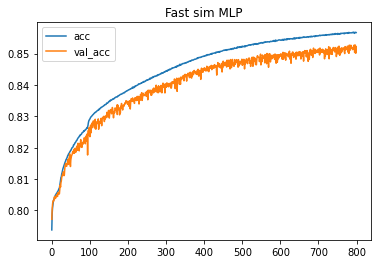

In [62]:
plt.plot(history.history["accuracy"], label="acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Fast sim MLP")
plt.legend();

In [13]:
loss, accuracy = model.evaluate(x_test, y_test)
print("Accuracy: ", accuracy)
print("loss: ", loss)

25001/25001 [==============================] - 40s 2ms/step - loss: 0.3420 - accuracy: 0.8521
Accuracy:  0.8521325588226318
loss:  0.34203726053237915


In [ ]:
model.save_weights("fast_sim_MLP.h5")

# Full sim dataset

In [16]:
f_full_train = h5py.File("/global/ml4hep/spss/mfong/transfer_learning/train.h5", 'r')
f_full_test = h5py.File("/global/ml4hep/spss/mfong/transfer_learning/test.h5", 'r')

In [17]:
x_full = np.concatenate([f_full_train[k][:num_samples] for k in feature_keys], axis=1)
x_full.shape

(4000068, 600)

In [18]:
y_full = f_full_train["labels"][:num_samples]
y_full.shape

(4000068,)

In [19]:
x_full_train = x_full[:num_train_samples]
y_full_train = y_full[:num_train_samples]

x_full_test = x_full[num_train_samples:]
y_full_test = y_full[num_train_samples:]

In [20]:
scaler_full = StandardScaler()
scaler_full.fit(x_full_train)

x_full_train = scaler_full.transform(x_full_train)
x_full_test = scaler_full.transform(x_full_test)

## Full sim using all data for a long time

In [63]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
x_full_all_data = np.concatenate([f_full_train[k] for k in feature_keys], axis=1)
x_full_all_data.shape

In [ ]:
y_full_all_data = f_full_train["labels"]
y_full_all_data.shape

In [ ]:
num_samples_all_data = len(y_full_all_data)
num_train_samples_all_data = int(0.8 * num_samples_all_data)
print("num_samples_all_data:", num_samples_all_data)
print("num_train_samples_all_data:", num_train_samples_all_data)

x_full_train_all_data = x_full_all_data[:num_train_samples_all_data]
y_full_train_all_data = y_full_all_data[:num_train_samples_all_data]

x_full_test_all_data = x_full_all_data[num_train_samples_all_data:]
y_full_test_all_data = y_full_all_data[num_train_samples_all_data:]

In [ ]:
model_full_all_data = Sequential()
model_full_all_data.add(Dense(64, input_shape=(600,), activation='relu'))
model_full_all_data.add(Dense(8, activation='relu'))
model_full_all_data.add(Dense(1, activation='sigmoid'))

In [ ]:
model_full_all_data.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
filepath="full_sim_all_data_best_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor="val_accuracy", verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history_full_all_data = model_full_all_data.fit(
    x_full_train,
    y_full_train,
    epochs=2000,
    batch_size=256,
    shuffle=True,
    callbacks=callbacks_list,
    validation_data=(x_full_test, y_full_test))

In [ ]:
model_full_all_data.save_weights("full_sim_all_data_2000epochs_MLP.h5")

## Fully Connected

In [21]:
model_full = Sequential()
model_full.add(Dense(64, input_shape=(600,), activation='relu'))
model_full.add(Dense(8, activation='relu'))
model_full.add(Dense(1, activation='sigmoid'))

In [22]:
model_full.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history_full = model_full.fit(x_full_train, y_full_train, epochs=800, batch_size=256, shuffle=True, validation_data=(x_full_test, y_full_test))

Epoch 1/800
12501/12501 [==============================] - 35s 3ms/step - loss: 0.5232 - accuracy: 0.7407 - val_loss: 0.5200 - val_accuracy: 0.7428
Epoch 2/800
12501/12501 [==============================] - 35s 3ms/step - loss: 0.5152 - accuracy: 0.7451 - val_loss: 0.5148 - val_accuracy: 0.7451
Epoch 3/800
12501/12501 [==============================] - 35s 3ms/step - loss: 0.5128 - accuracy: 0.7465 - val_loss: 0.5136 - val_accuracy: 0.7459
Epoch 4/800
12501/12501 [==============================] - 35s 3ms/step - loss: 0.5111 - accuracy: 0.7473 - val_loss: 0.5133 - val_accuracy: 0.7459
Epoch 5/800
12501/12501 [==============================] - 35s 3ms/step - loss: 0.5095 - accuracy: 0.7481 - val_loss: 0.5112 - val_accuracy: 0.7468
Epoch 6/800
12501/12501 [==============================] - 35s 3ms/step - loss: 0.5078 - accuracy: 0.7491 - val_loss: 0.5095 - val_accuracy: 0.7479
Epoch 7/800
12501/12501 [==============================] - 36s 3ms/step - loss: 0.5059 - accuracy: 0.7500 - val_

12501/12501 [==============================] - 36s 3ms/step - loss: 0.4380 - accuracy: 0.7942 - val_loss: 0.4460 - val_accuracy: 0.7898
Epoch 57/800
12501/12501 [==============================] - 37s 3ms/step - loss: 0.4376 - accuracy: 0.7946 - val_loss: 0.4450 - val_accuracy: 0.7905
Epoch 58/800
12501/12501 [==============================] - 37s 3ms/step - loss: 0.4371 - accuracy: 0.7947 - val_loss: 0.4453 - val_accuracy: 0.7907
Epoch 59/800
12501/12501 [==============================] - 37s 3ms/step - loss: 0.4366 - accuracy: 0.7951 - val_loss: 0.4462 - val_accuracy: 0.7902
Epoch 60/800
12501/12501 [==============================] - 36s 3ms/step - loss: 0.4362 - accuracy: 0.7954 - val_loss: 0.4472 - val_accuracy: 0.7902
Epoch 61/800
12501/12501 [==============================] - 35s 3ms/step - loss: 0.4356 - accuracy: 0.7956 - val_loss: 0.4459 - val_accuracy: 0.7906
Epoch 62/800
12501/12501 [==============================] - 36s 3ms/step - loss: 0.4352 - accuracy: 0.7960 - val_loss: 

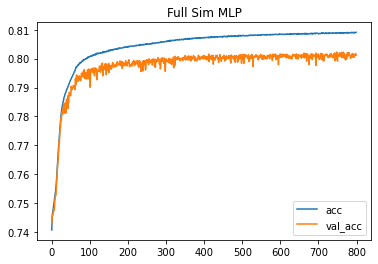

In [34]:
plt.plot(history_full.history["accuracy"], label="acc")
plt.plot(history_full.history["val_accuracy"], label="val_acc")
plt.title("Full Sim MLP")
plt.legend();

In [ ]:
model_full.save_weights("full_sim_MLP.h5")

## Use pretrained weights on full sim

In [ ]:
model_pretrained = Sequential()
model_pretrained.add(Dense(64, input_shape=(600,), activation='relu'))
model_pretrained.add(Dense(8, activation='relu'))
model_pretrained.add(Dense(1, activation='sigmoid'))

In [ ]:
model_pretrained.load_weights("fast_sim_MLP.h5")

In [ ]:
model_pretrained.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history_pretrained = model_pretrained.fit(x_full_train, y_full_train, epochs=800, batch_size=256, shuffle=True, validation_data=(x_full_test, y_full_test))

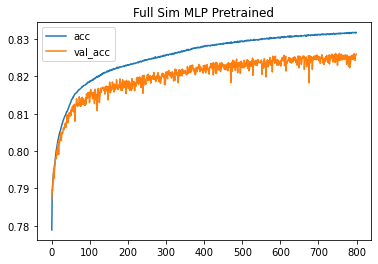

In [32]:
plt.plot(history_pretrained.history["accuracy"], label="acc")
plt.plot(history_pretrained.history["val_accuracy"], label="val_acc")
plt.title("Full Sim MLP Pretrained")
plt.legend();

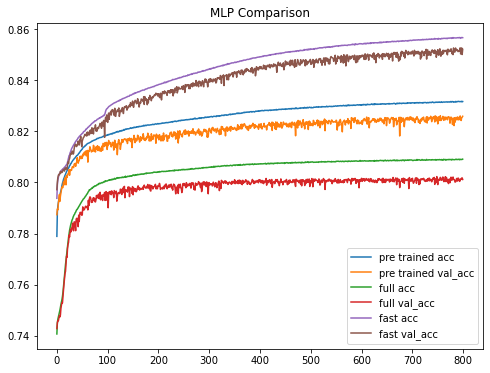

In [43]:
plt.figure(figsize=(8,6))
plt.plot(history_pretrained.history["accuracy"], label="pre trained acc")
plt.plot(history_pretrained.history["val_accuracy"], label="pre trained val_acc")

plt.plot(history_full.history["accuracy"], label="full acc")
plt.plot(history_full.history["val_accuracy"], label="full val_acc")

plt.plot(history.history["accuracy"], label="fast acc")
plt.plot(history.history["val_accuracy"], label="fast val_acc")
plt.title("MLP Comparison")
plt.legend();

In [ ]:
# TODO

# email kevin this plot with some inital results
# use all fullsim and train fully from scratch


# pre train on full sim 4 mill - then take the next 4 mill train/validation

# try cos(phi) / sin(phi)
# try logE instead of E/pT, then standard scalar

In [41]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [40]:
# roc curve calcs
print("Fast sim")
y_pred_test = model.predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
print("Full sim")
y_pred_test_full = model_full.predict(x_full_test)
fpr_full, tpr_full, thresholds_full = roc_curve(y_full_test, y_pred_test_full)
print("Full sim pretrained")
y_pred_test_pretrained = model_pretrained.predict(x_full_test)
fpr_pretrained, tpr_pretrained, thresholds_pretrained = roc_curve(y_full_test, y_pred_test_pretrained)

Fast sim
Full sim
Full sim pretrained


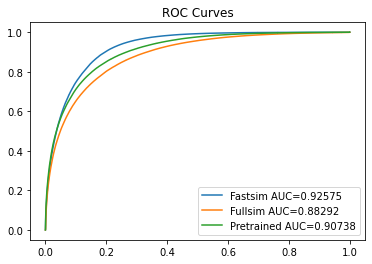

In [38]:
plt.plot(fpr, tpr, label="Fastsim AUC={0:.5f}".format(auc(fpr, tpr)))
plt.plot(fpr_full, tpr_full, label="Fullsim AUC={0:.5f}".format(auc(fpr_full, tpr_full)))
plt.plot(fpr_pretrained, tpr_pretrained, label="Pretrained AUC={0:.5f}".format(auc(fpr_pretrained, tpr_pretrained)))
plt.title("ROC Curves")
plt.legend();

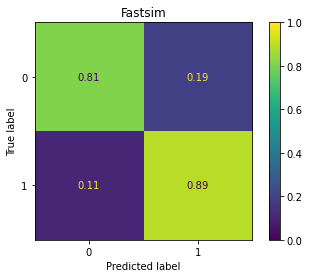

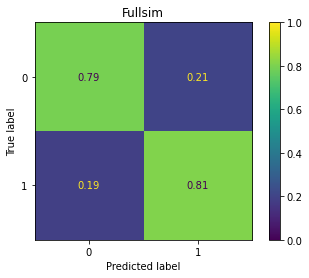

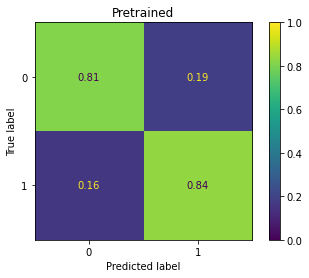

In [60]:
cm = confusion_matrix(y_test, (y_pred_test > 0.5), normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
disp.im_.set_clim(0, 1)
plt.title("Fastsim")
plt.show()

cm = confusion_matrix(y_full_test, (y_pred_test_full > 0.5), normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
disp.im_.set_clim(0, 1)
plt.title("Fullsim")
plt.show()

cm = confusion_matrix(y_full_test, (y_pred_test_pretrained > 0.5), normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
disp.im_.set_clim(0, 1)
plt.title("Pretrained")
plt.show()